In [60]:
### Import 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno # To get visual representation of missing values
from plotly.subplots import make_subplots
import plotly.graph_objects as go


%matplotlib inline
import seaborn as sns
import missingno as msno # To get visual representation of missing values

import opendatasets as od


import math
import scipy.stats as stats
from scipy.stats import skew
import statsmodels.api as sm

import sklearn.compose 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



import warnings
warnings.filterwarnings('ignore') # To ignore the warnings

In [61]:
%matplotlib inline
sns.set_style(style='whitegrid')
sns.set_context(context ='notebook')
plt.rcParams['figure.figsize'] = (11, 9.4)

### Data description
1. *Date:*  The date of observation
2. *Location:* The common name of the location of the weather station
3. *MinTemp*: The minimum temperature in degrees celsius
4. *MaxTemp*: The maximum temperature in degrees celsius
5. *Rainfall*: The amount of rainfall recorded for the day in mm
6. *Evaporation*: The so-called Class A pan evaporation (mm) in the 24 hours to 9am
7. *Sunshine*: he number of hours of bright sunshine in the day.
8. *WindGustDir*: The direction of the strongest wind gust in the 24 hours to midnight
9. *WindGustSpeed*: The speed (km/h) of the strongest wind gust in the 24 hours to midnight
10. *WindDir9am*: Direction of the wind at 9am

### 1. Download dataset

In [62]:
df = pd.read_csv('../../data/interim/weather-dataset-rattle-package/weatherAUS.csv')
df.sample(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
100841,2012-08-20,MountGambier,6.8,15.4,0.6,1.0,5.3,N,41.0,N,...,92.0,64.0,1018.8,1014.7,7.0,7.0,9.5,14.1,No,Yes
67218,2008-07-19,Melbourne,6.4,14.1,1.6,1.4,1.4,N,72.0,N,...,74.0,55.0,1012.5,1009.2,7.0,7.0,8.3,13.0,Yes,No
29842,2016-07-27,Richmond,4.4,19.0,0.0,3.2,NaN,W,70.0,NW,...,54.0,41.0,1012.7,1014.5,NaN,1.0,15.4,17.4,No,No
61729,2010-07-02,Sale,-1.1,13.6,0.0,1.2,5.4,W,28.0,WNW,...,96.0,54.0,1025.7,1022.5,1.0,6.0,1.2,12.4,No,No
58176,2009-01-04,Bendigo,10.1,31.9,0.0,6.8,NaN,W,43.0,S,...,28.0,6.0,1015.0,1012.0,1.0,5.0,20.9,30.2,No,No


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

## Preparing the Data for Training

We'll perform the following steps to prepare the dataset for training:

1. Create a train/test/validation split
2. Identify input and target columns
3. Identify numeric and categorical columns
4. Impute (fill) missing numeric values
5. Scale numeric values to the $(0, 1)$ range
6. Encode categorical columns to one-hot vectors

### Training, Validation and Test Sets

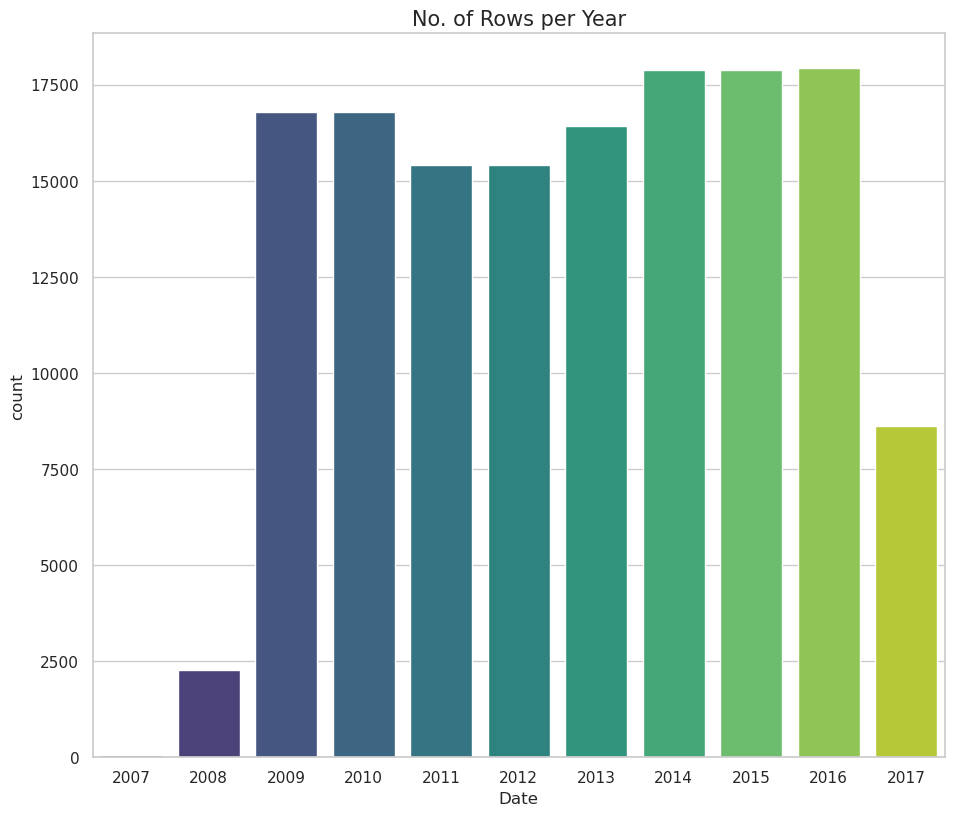

In [64]:
plt.title('No. of Rows per Year', fontsize = 15)
sns.countplot(
    x = pd.to_datetime(df.Date).dt.year,
    palette = 'viridis'
);

While working with chronological data, it's often a good idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.

We'll use the data till 2014 for the training set, data from 2015 for the validation set, and the data from 2016 & 2017 for the test set.  

In [65]:
df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [66]:
df['WindGustDir'].fillna(df['WindGustDir'].mode()[0], inplace=True)
df['WindDir9am'].fillna(df['WindDir9am'].mode()[0], inplace=True)
df['WindDir3pm'].fillna(df['WindDir3pm'].mode()[0], inplace=True)
df['RainToday'].fillna(df['RainToday'].mode()[0], inplace=True)
df['RainTomorrow'].fillna(df['RainTomorrow'].mode()[0], inplace=True)

In [67]:
year = pd.to_datetime(df.Date).dt.year

train_df = df[year < 2015]
val_df = df[year == 2015]
test_df = df[year > 2015]

print(f'train_df.shape: {train_df.shape}')
print(f'val_df.shape: {val_df.shape}')
print(f'test_df.shape: {test_df.shape}')

train_df.shape: (101018, 23)
val_df.shape: (17885, 23)
test_df.shape: (26557, 23)


### Input and Target Columns

Let's identify the input and target columns.

In [68]:
input_cols = list(df.columns)[1:-1]
target_col = 'RainTomorrow'

In [69]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

Let's also identify the numeric and categorical columns.

In [70]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [71]:
print('Numeric columns:', numeric_cols)
print('Categorical columns:', categorical_cols)

Numeric columns: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
Categorical columns: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


### Imputing missing numeric values

In [72]:
from sklearn.impute import SimpleImputer

In [73]:
imputer = SimpleImputer(strategy='mean').fit(df[numeric_cols])

In [74]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [75]:
test_inputs[numeric_cols].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

### Scaling Numeric Features 

In [76]:
from sklearn.preprocessing import MinMaxScaler

In [77]:
scaler = MinMaxScaler().fit(df[numeric_cols])

In [78]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [79]:
val_inputs.describe().loc[['min', 'max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,0.007075,0.030246,0.000000,0.000000,0.0,0.007752,0.000000,0.000000,0.04,0.0,0.125620,0.0816,0.000000,0.000000,0.021097,0.026871
max,0.952830,0.948960,0.666307,0.485517,1.0,1.000000,0.669231,0.850575,1.00,1.0,0.971901,0.9632,0.888889,0.888889,0.943038,0.925144


### Encoding Categorical Data

In [80]:
from sklearn.preprocessing import OneHotEncoder

In [81]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(df[categorical_cols])

In [82]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [83]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [84]:
test_inputs

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_No,RainToday_Yes
2498,Albury,0.681604,0.801512,0.000000,0.037712,0.524909,ENE,0.372093,N,ESE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2499,Albury,0.693396,0.725898,0.001078,0.037712,0.524909,SSE,0.341085,SSE,SE,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2500,Albury,0.634434,0.527410,0.005930,0.037712,0.524909,ENE,0.325581,ESE,ENE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2501,Albury,0.608491,0.538752,0.042049,0.037712,0.524909,SSE,0.255814,SE,SSE,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2502,Albury,0.566038,0.523629,0.018329,0.037712,0.524909,ENE,0.193798,SE,SSE,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,0.266509,0.533081,0.000000,0.037712,0.524909,E,0.193798,SE,ENE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
145456,Uluru,0.285377,0.568998,0.000000,0.037712,0.524909,NNW,0.124031,SE,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
145457,Uluru,0.327830,0.599244,0.000000,0.037712,0.524909,N,0.240310,SE,WNW,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
145458,Uluru,0.384434,0.601134,0.000000,0.037712,0.524909,SE,0.170543,SSE,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


As a final step, let's drop the textual categorical columns, so that we're left with just numeric data.



In [85]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [86]:
X_test

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_No,RainToday_Yes
2498,0.681604,0.801512,0.000000,0.037712,0.524909,0.372093,0.000000,0.080460,0.46,0.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2499,0.693396,0.725898,0.001078,0.037712,0.524909,0.341085,0.069231,0.195402,0.54,0.30,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2500,0.634434,0.527410,0.005930,0.037712,0.524909,0.325581,0.084615,0.448276,0.62,0.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2501,0.608491,0.538752,0.042049,0.037712,0.524909,0.255814,0.069231,0.195402,0.74,0.65,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2502,0.566038,0.523629,0.018329,0.037712,0.524909,0.193798,0.046154,0.103448,0.92,0.63,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,0.266509,0.533081,0.000000,0.037712,0.524909,0.193798,0.100000,0.126437,0.51,0.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
145456,0.285377,0.568998,0.000000,0.037712,0.524909,0.124031,0.100000,0.103448,0.56,0.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
145457,0.327830,0.599244,0.000000,0.037712,0.524909,0.240310,0.069231,0.103448,0.53,0.24,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
145458,0.384434,0.601134,0.000000,0.037712,0.524909,0.170543,0.100000,0.080460,0.51,0.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Training and Visualizing Decision Trees

In [87]:
from sklearn.tree import DecisionTreeClassifier

In [88]:
model = DecisionTreeClassifier(random_state=42)

In [91]:
train_targets.isnull().sum()

0

In [92]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(random_state=42)

An optimal decision tree has now been created using the training data.

### Evaluation

Let's evaluate the decision tree using the accuracy score.

In [93]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [94]:
train_preds = model.predict(X_train)

In [96]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [97]:
pd.value_counts(train_preds)

No     78740
Yes    22278
Name: count, dtype: int64

In [99]:
train_probs = model.predict_proba(X_train)

In [100]:
train_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Seems like the decision tree is quite confident about its predictions.

Let's check the accuracy of its predictions.

In [101]:
accuracy_score(train_targets, train_preds)

0.9999505038705974

The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too. 

We can make predictions and compute accuracy in one step using `model.score`

In [102]:
model.score(X_val, val_targets)

0.7941291585127201

Although the training accuracy is 100%, the accuracy on the validation set is just about 79%, which is only marginally better then always predicting "No". 

In [104]:
val_targets.value_counts() / len(val_targets)

RainTomorrow
No     0.79603
Yes    0.20397
Name: count, dtype: float64

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

### Visualization

We can visualize the decision tree _learned_ from the training data.

In [105]:
from sklearn.tree import plot_tree, export_text

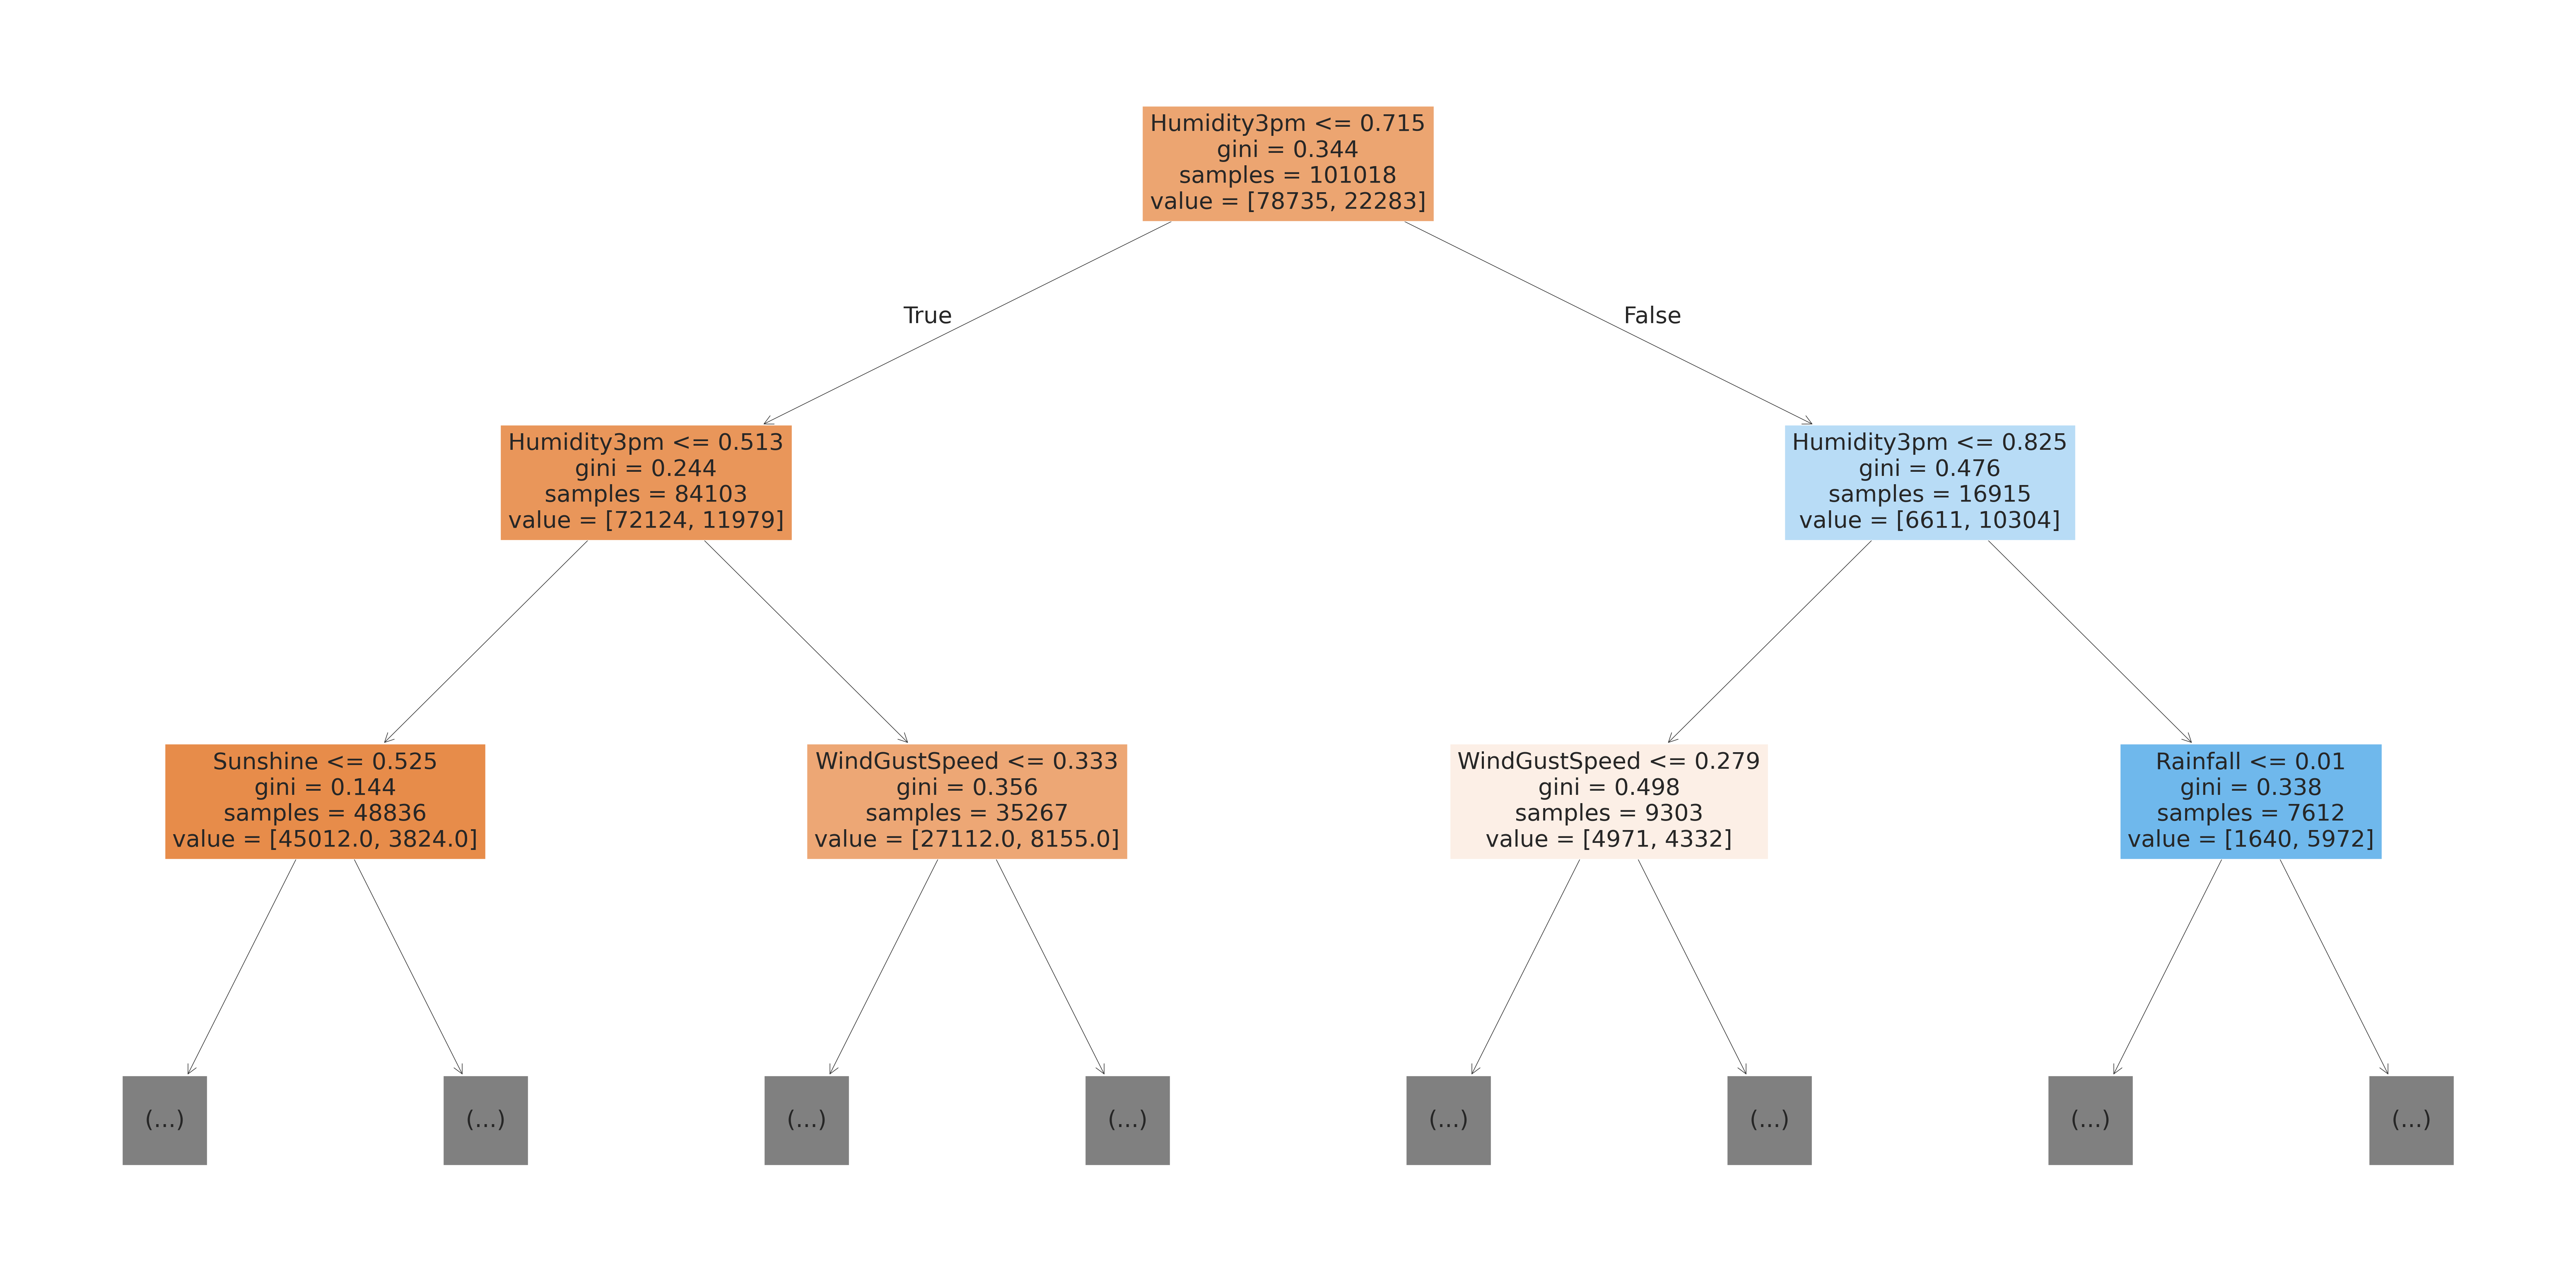

In [107]:
plt.figure(figsize=(80, 40))
plot_tree(
    model,
    feature_names=X_train.columns,
    max_depth=2,
    filled=True
);

Can you see how the model classifies a given input as a series of decisions? The tree is truncated here, but following any path from the root node down to a leaf will result in "Yes" or "No". Do you see how a decision tree differs from a logistic regression model?

How a Decision Tree is Created

Note the gini value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect split (only one class on each side) has a Gini index of 0.

Let's check the depth of the tree that was created.

In [108]:
model.tree_.max_depth

44

We can also display the tree as text, which can be easier to follow for deeper trees.

In [109]:
tree_text = export_text(
    model,
    max_depth=10,
    feature_names= list(X_train.columns),
)
print(tree_text)

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- Pressure3pm <= 0.44
|   |   |   |   |   |--- Humidity3pm <= 0.24
|   |   |   |   |   |   |--- WindGustDir_N <= 0.50
|   |   |   |   |   |   |   |--- WindSpeed9am <= 0.32
|   |   |   |   |   |   |   |   |--- Pressure3pm <= 0.44
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.06
|   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  0.06
|   |   |   |   |   |   |   |   |   |   |--- Temp9am <= 0.65
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- Temp9am >  0.65
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |--- Pressure3pm >  0.44
|   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- WindSpeed9am >  0.32
|   |   |   |   |   |   |   | 

### Feature Importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [110]:
model.feature_importances_

array([3.77929476e-02, 3.37343371e-02, 4.14077726e-02, 2.19450166e-02,
       4.66048322e-02, 6.54894193e-02, 2.80150360e-02, 3.07586111e-02,
       3.58777569e-02, 2.66298339e-01, 3.59122643e-02, 6.05230733e-02,
       1.36614388e-02, 1.83112789e-02, 3.70580093e-02, 3.40535771e-02,
       2.30362596e-03, 1.62088557e-03, 1.21423400e-03, 5.16998549e-04,
       1.46324029e-03, 1.32541561e-03, 1.29166000e-03, 1.87768091e-03,
       8.81913107e-04, 1.61782791e-03, 8.51929250e-04, 2.09781327e-03,
       1.55706864e-03, 3.48536350e-04, 6.40134955e-04, 2.50526669e-03,
       4.59913595e-05, 1.08897044e-03, 1.56847726e-03, 1.31781566e-03,
       8.84167570e-04, 8.95043863e-04, 1.51123339e-03, 1.76922752e-03,
       2.65034681e-04, 8.58795968e-04, 1.39169460e-03, 1.82486057e-03,
       1.06149971e-03, 1.62454032e-03, 5.10818797e-04, 1.42813683e-03,
       1.16004885e-03, 1.90769030e-03, 1.11531323e-03, 1.82938442e-03,
       9.36066851e-04, 1.97159334e-03, 1.20819260e-03, 3.55194360e-04,
      

Let's turn this into a dataframe and visualize the most important features.

In [111]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [112]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.266298
5,WindGustSpeed,0.065489
11,Pressure3pm,0.060523
4,Sunshine,0.046605
2,Rainfall,0.041408
0,MinTemp,0.037793
14,Temp9am,0.037058
10,Pressure9am,0.035912
8,Humidity9am,0.035878
15,Temp3pm,0.034054


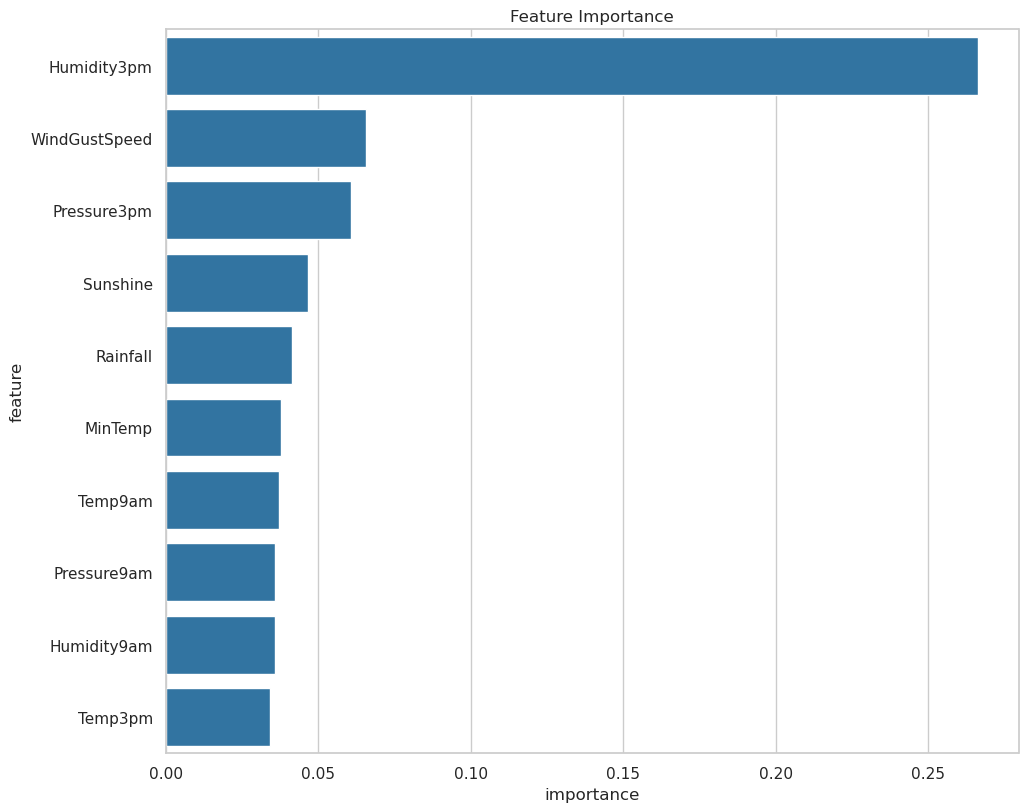

In [113]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning and Overfitting

As we saw in the previous section, our decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting. 


The `DecisionTreeClassifier` accepts several arguments, some of which can be modified to reduce overfitting.

In [115]:
#?DecisionTreeClassifier

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data. We'll explore a couple of hyperparameters:

- `max_depth`
- `max_leaf_nodes`

### `max_depth`

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [116]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)

In [117]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=3, random_state=42)

We can compute the accuracy of the model on the training and validation sets using `model.score`

In [118]:
model.score(X_train, train_targets)

0.8302678730523273

In [120]:
model.score(X_val, val_targets)

0.837573385518591

Great, while the training accuracy of the model has gone down, the validation accuracy of the model has increased significantly.

In [121]:
model.classes_

array(['No', 'Yes'], dtype=object)

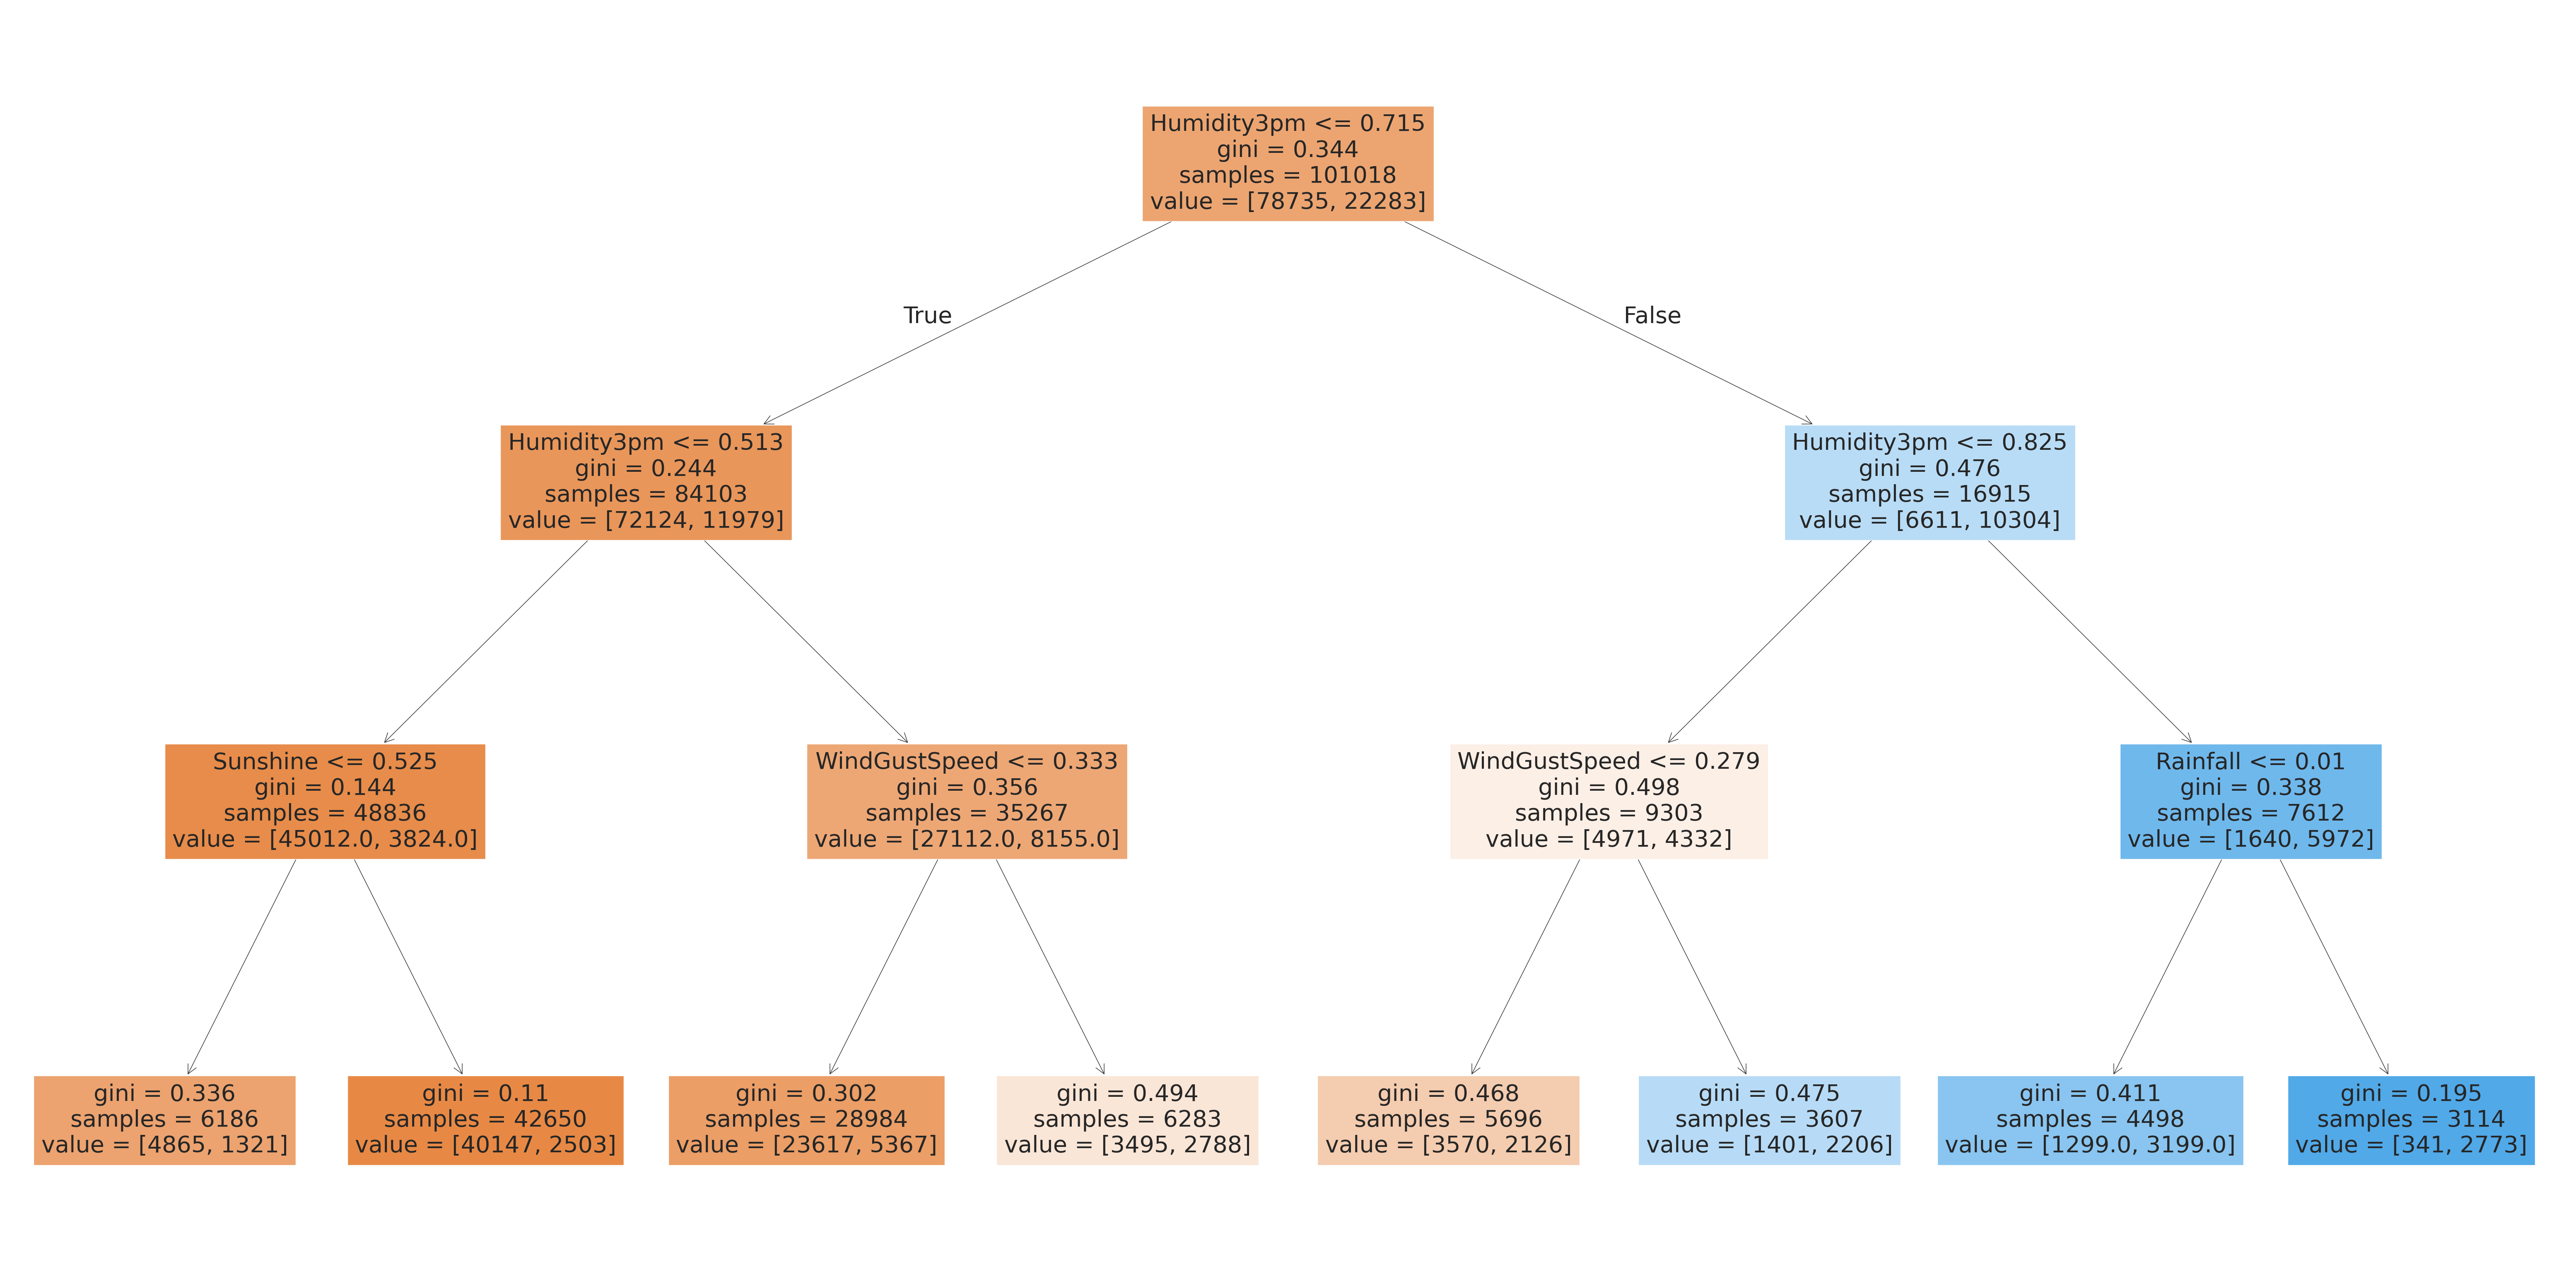

In [122]:
plt.figure(figsize=(80, 40))
plot_tree(
    model,
    feature_names=X_train.columns,
    max_depth=3,
    filled=True
);

In [123]:
print(export_text(model, max_depth=3, feature_names=list(X_train.columns)))

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Sunshine <= 0.52
|   |   |   |--- class: No
|   |   |--- Sunshine >  0.52
|   |   |   |--- class: No
|   |--- Humidity3pm >  0.51
|   |   |--- WindGustSpeed <= 0.33
|   |   |   |--- class: No
|   |   |--- WindGustSpeed >  0.33
|   |   |   |--- class: No
|--- Humidity3pm >  0.72
|   |--- Humidity3pm <= 0.82
|   |   |--- WindGustSpeed <= 0.28
|   |   |   |--- class: No
|   |   |--- WindGustSpeed >  0.28
|   |   |   |--- class: Yes
|   |--- Humidity3pm >  0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- class: Yes
|   |   |--- Rainfall >  0.01
|   |   |   |--- class: Yes



Let's experiment with different depths using a helper function.

In [124]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_acc = 1 - model.score(X_train, train_targets)
    val_acc = 1 - model.score(X_val, val_targets)
    return {'max_depth': md, 'train_error': train_acc, 'val_error': val_acc}

In [125]:
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

In [126]:
errors_df

,max_depth,train_error,val_error
0,1,0.184027,0.175342
1,2,0.177701,0.167906
2,3,0.169732,0.162427
3,4,0.165367,0.160134
4,5,0.158942,0.155605
5,6,0.156477,0.154040
6,7,0.152329,0.161476
7,8,0.148142,0.161700
8,9,0.142430,0.161532
9,10,0.135105,0.159128


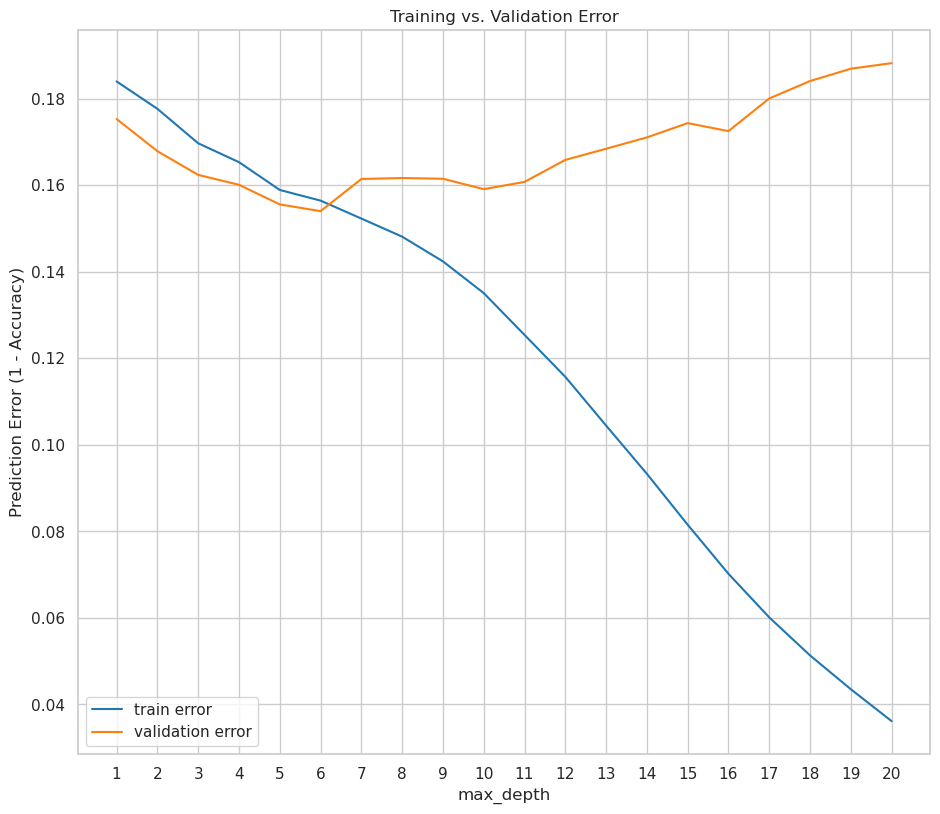

In [132]:
plt.plot(errors_df['max_depth'], errors_df['train_error'], label='train error');
plt.plot(errors_df['max_depth'], errors_df['val_error'], label='validation error');
plt.title('Training vs. Validation Error')
plt.xticks(range(1, 21))
plt.xlabel('max_depth');
plt.ylabel('Prediction Error (1 - Accuracy)');
plt.legend()


This is a common pattern you'll see with all machine learning algorithms:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">




You'll often need to tune hyperparameters carefully to find the optimal fit. In the above case, it appears that a maximum depth of 7 results in the lowest validation error.

In [133]:
model = DecisionTreeClassifier(max_depth=7, random_state=42).fit(
    X_train, train_targets
)

model.score(X_train, train_targets)

0.8476707121503099

### `max_leaf_nodes`

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

In [134]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [135]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [137]:
model.score(X_train, train_targets)

0.8497198519075808

In [138]:
model.score(X_val, val_targets)

0.8401453732177803

In [140]:
model.tree_.max_depth

11

Notice that the model was able to achieve a greater depth of 12 for certain paths while keeping other paths shorter.

In [142]:
model_text = export_text(
    model,
    feature_names= list(X_train.columns),
)
print(model_text[:3000])

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- Pressure3pm <= 0.44
|   |   |   |   |   |--- Humidity3pm <= 0.24
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.24
|   |   |   |   |   |   |--- Sunshine <= 0.37
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Sunshine >  0.37
|   |   |   |   |   |   |   |--- class: No
|   |   |   |   |--- Pressure3pm >  0.44
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.28
|   |   |   |   |   |   |--- Cloud3pm <= 0.39
|   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |--- Cloud3pm >  0.39
|   |   |   |   |   |   |   |--- Location_Hobart <= 0.50
|   |   |   |   |   |   |   |   |--- WindGustSpeed <= 0.23
|   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |--- WindGustSpeed >  0.23

### Training a Random Forest

We'll use the RandomForestClassifier class from sklearn.ensemble.

In [143]:
from sklearn.ensemble import RandomForestClassifier

In [144]:
model = RandomForestClassifier(n_jobs=1, random_state=42)

`n_jobs` allows the random forest to use mutiple parallel workers to train decision trees, and `random_state=42` ensures that the we get the same results for each execution.

In [145]:
model.fit(X_train, train_targets)

RandomForestClassifier(n_jobs=1, random_state=42)

In [146]:
model.score(X_train, train_targets)

0.9999307054188362

In [147]:
model.score(X_val, val_targets)

0.8561364271736092

Once again, the training accuracy is almost 100%, but this time the validation accuracy is much better. In fact, it is better than the best single decision tree we had trained so far. Do you see the power of random forests?

This general technique of combining the results of many models is called "ensembling", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

<img src="https://i.imgur.com/qJo8D8b.png" width="640">


We can also look at the probabilities for the predictions. The probability of a class is simply the fraction of trees which that predicted the given class.

In [148]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.97, 0.03],
       [0.99, 0.01],
       [0.99, 0.01],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.95, 0.05]])

We can access individual decision trees using `model.estimators_`

In [150]:
model.estimators_[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)

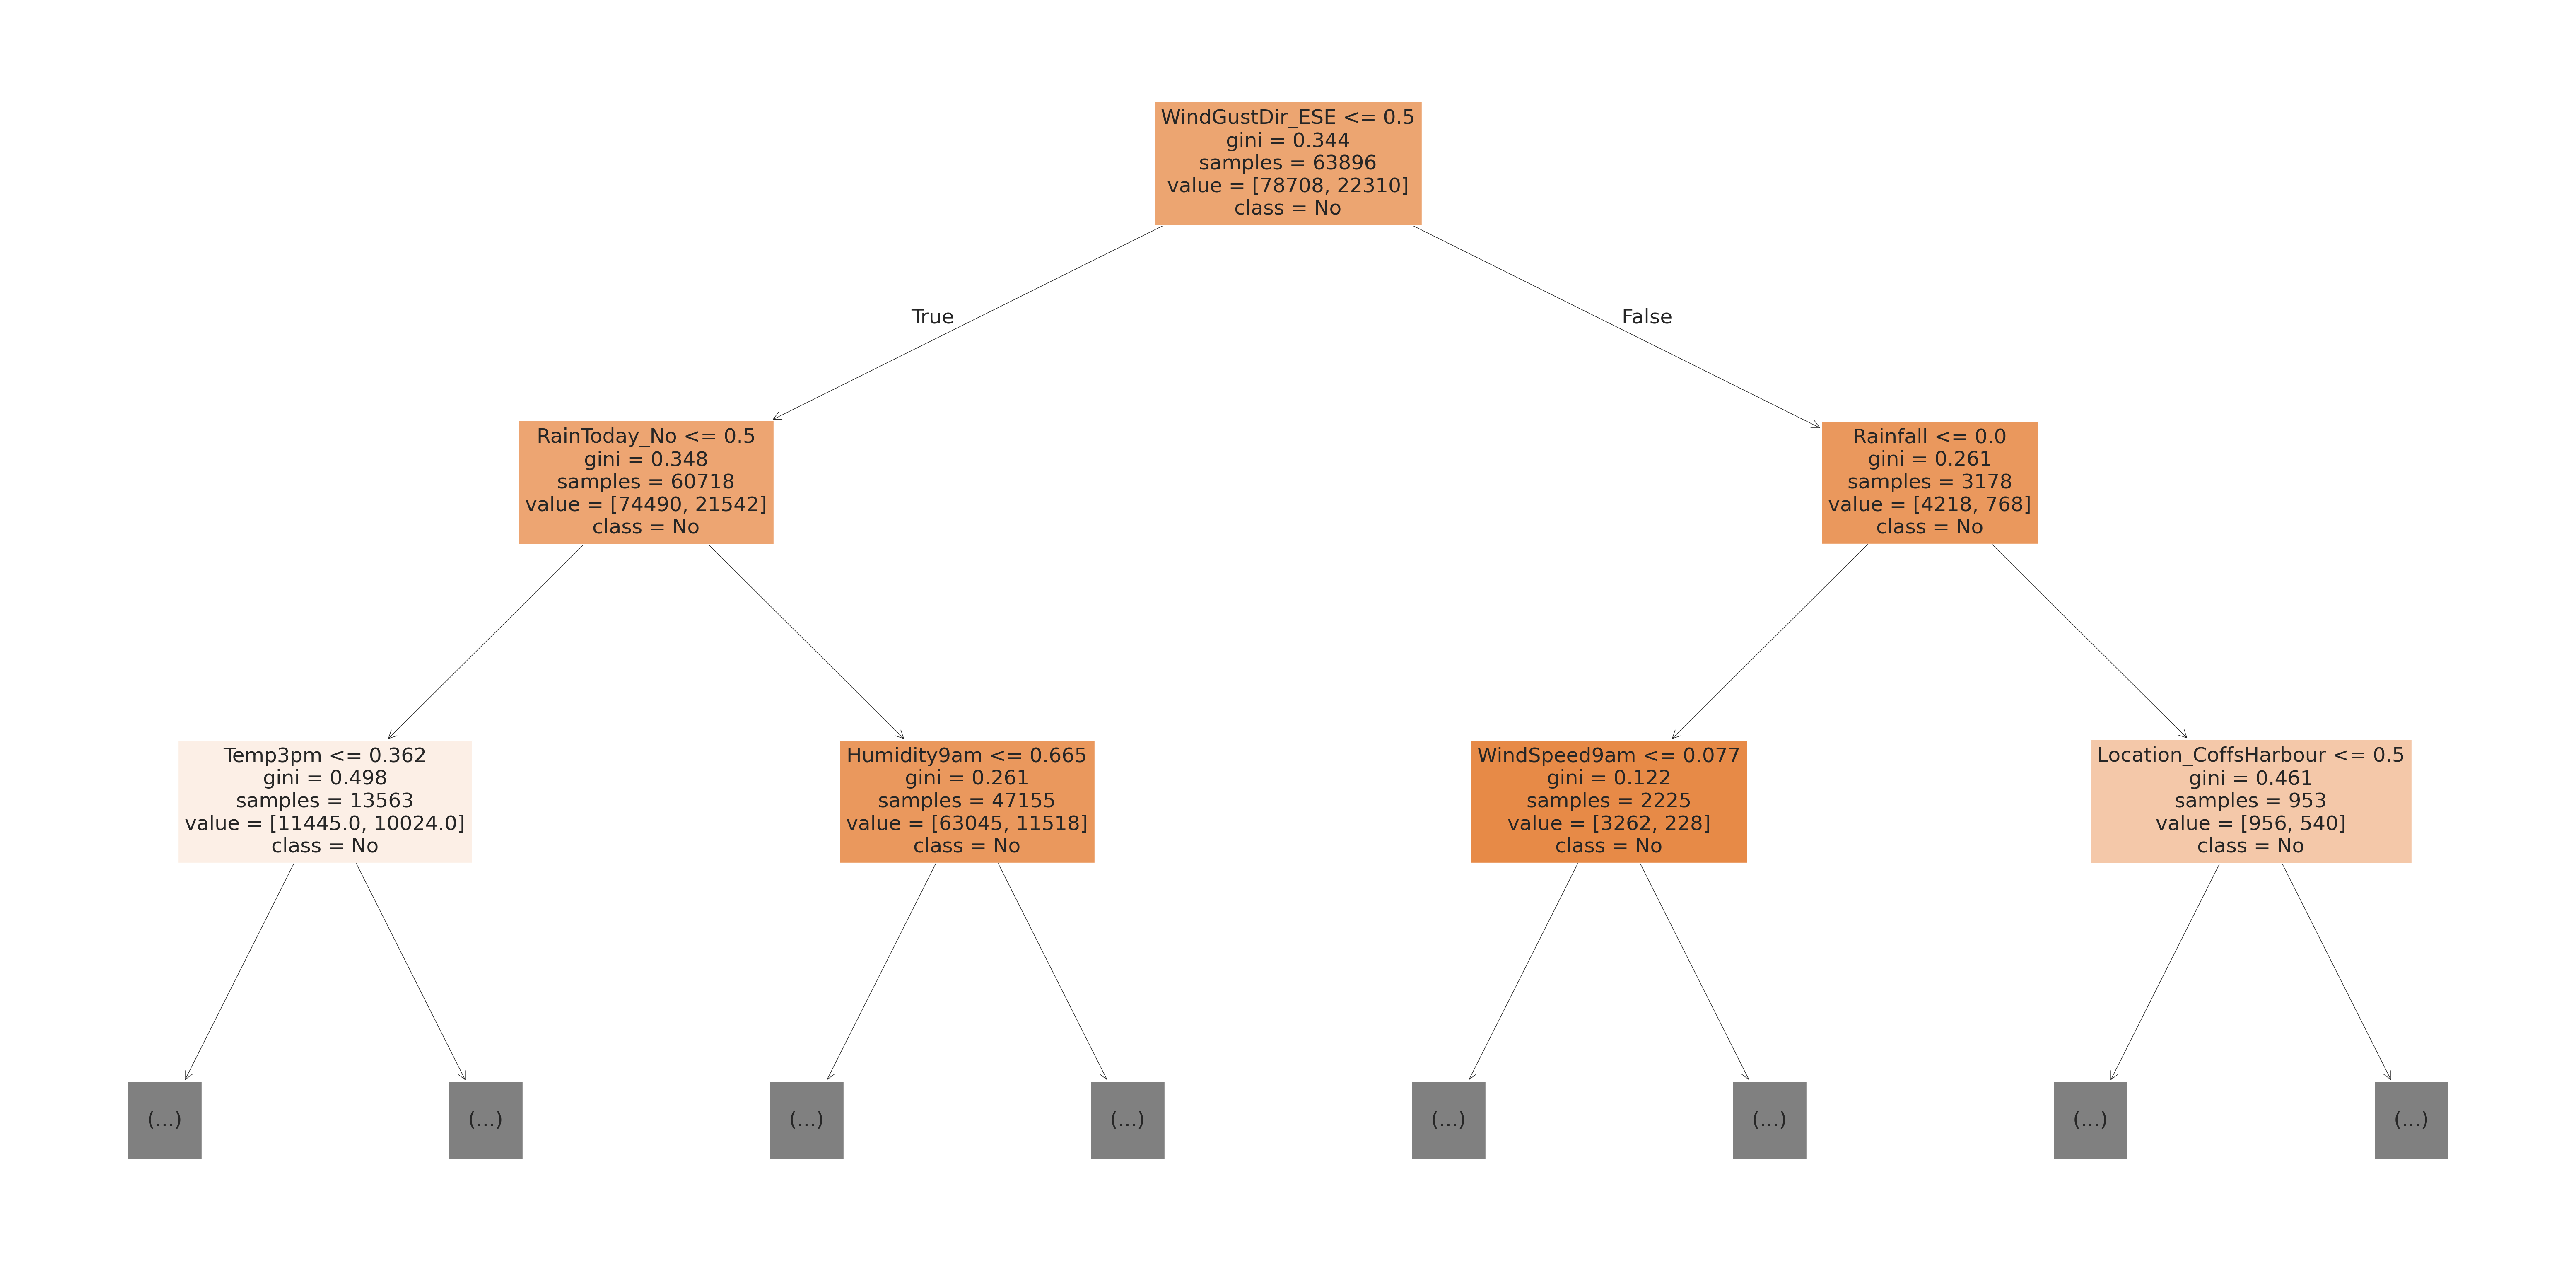

In [154]:
plt.figure(figsize=(80, 40))
plot_tree(
    model.estimators_[0],
    feature_names=X_train.columns,
    max_depth=2,
    filled=True,
    class_names=model.classes_
);

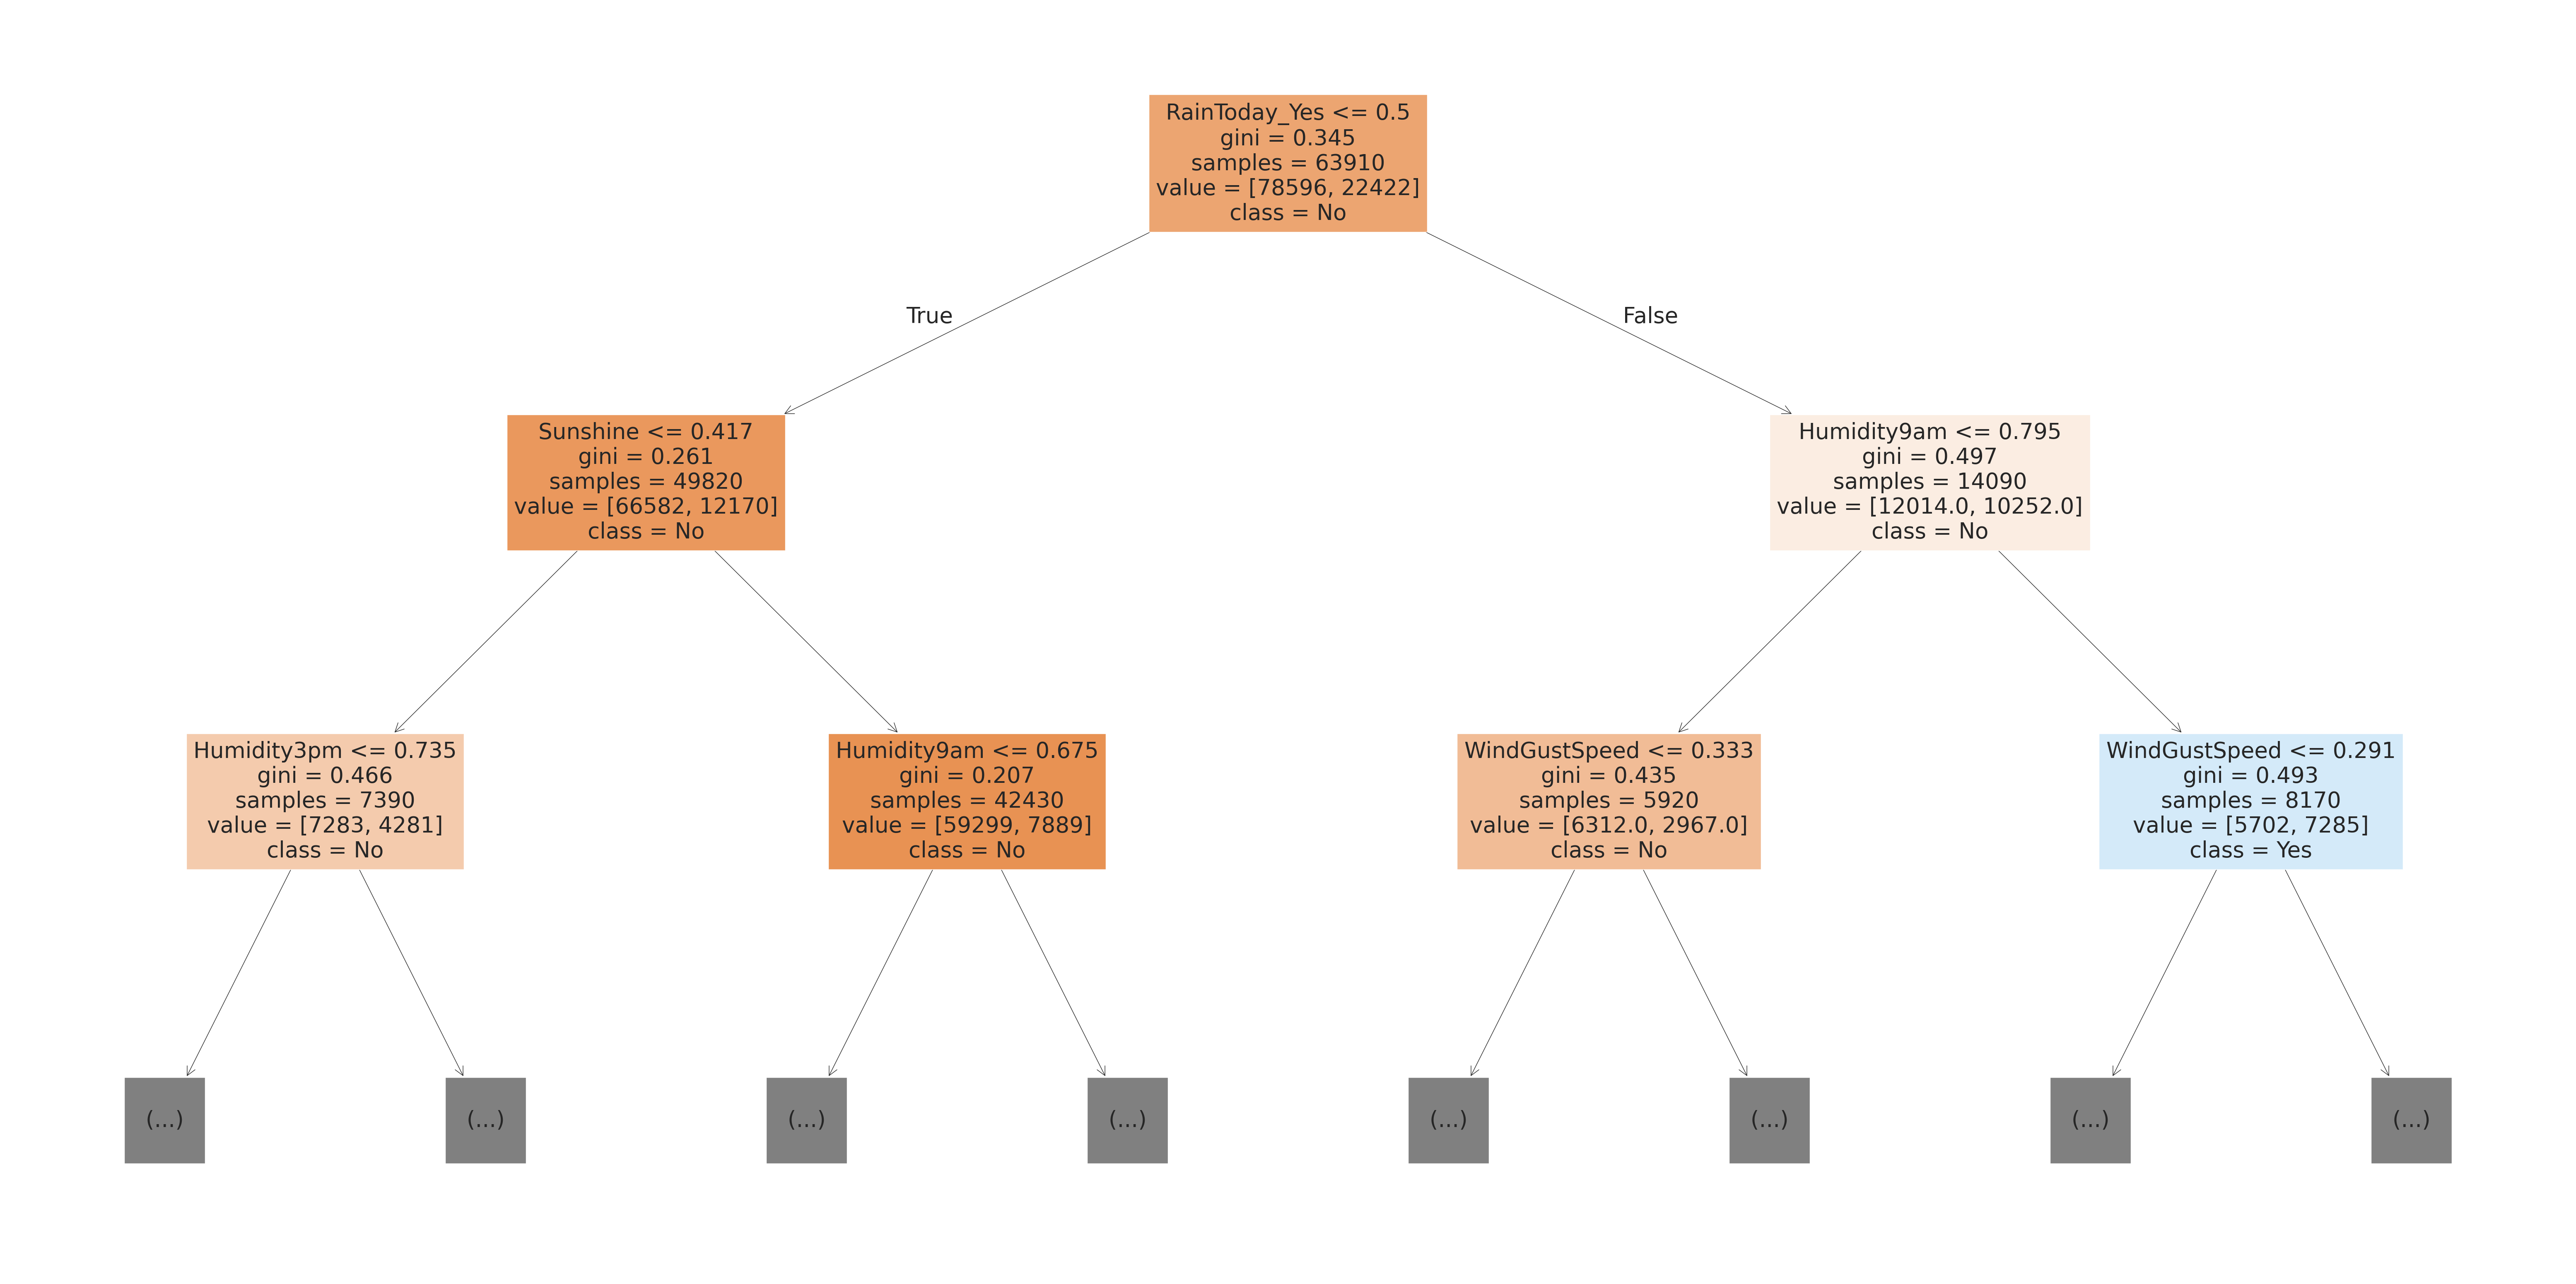

In [153]:
plt.figure(figsize=(80, 40))
plot_tree(
    model.estimators_[20],
    feature_names=X_train.columns,
    max_depth=2,
    filled=True,
    class_names=model.classes_
);

In [155]:
len(model.estimators_)

100

Just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees.

In [157]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [158]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.132102
4,Sunshine,0.054464
11,Pressure3pm,0.053066
2,Rainfall,0.050864
8,Humidity9am,0.050197
10,Pressure9am,0.049453
5,WindGustSpeed,0.048658
15,Temp3pm,0.045885
0,MinTemp,0.042594
1,MaxTemp,0.042558


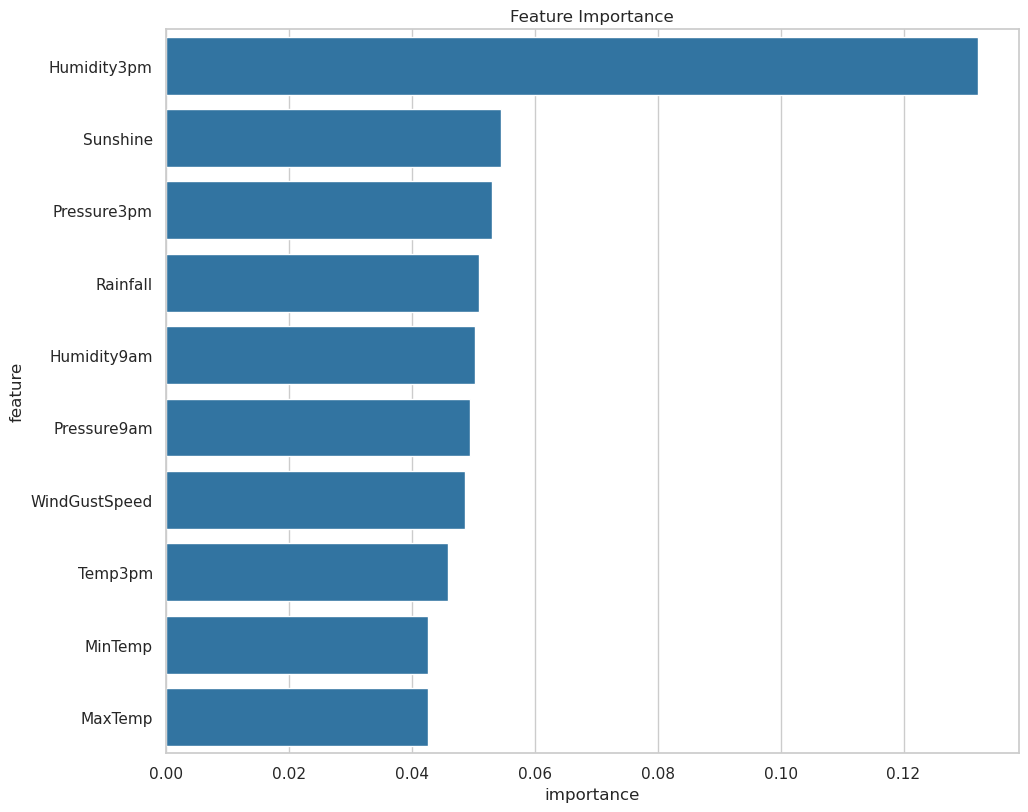

In [159]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Notice that the distribution is a lot less skewed than that for a single decision tree.

## Hyperparameter Tuning with Random Forests

Just like decision trees, random forests also have several hyperparameters. In fact many of these hyperparameters are applied to the underlying decision trees. 

Let's study some the hyperparameters for random forests. You can learn more about them here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Let's create a base model with which we can compare models with tuned hyperparameters.

In [160]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, train_targets)

In [161]:
base_train_acc = base_model.score(X_train, train_targets)
base_val_acc = base_model.score(X_val, val_targets)

In [162]:
base_accs = base_train_acc, base_val_acc
base_accs

(0.9999307054188362, 0.8561364271736092)

We can use this as a benchmark for hyperparmeter tuning.

### `n_estimators`

This argument controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed. 


**10 estimators**

In [163]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10)

In [164]:
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [165]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9864182620919044, 0.8442270058708415)

In [166]:
base_accs

(0.9999307054188362, 0.8561364271736092)

**500 estimators**

In [167]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500)
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [168]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9999505038705974, 0.8583729382163825)

In [169]:
base_accs

(0.9999307054188362, 0.8561364271736092)

### `max_depth` and `max_leaf_nodes`

These arguments are passed directly to each decision tree, and control the maximum depth and max. no leaf nodes of each tree respectively. By default, no maximum depth is specified, which is why each tree has a training accuracy of 100%. You can specify a `max_depth` to reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Let's define a helper function `test_params` to make it easy to test hyperparameters.

In [170]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_acc = model.score(X_train, train_targets)
    val_acc = model.score(X_val, val_targets)
    return train_acc, val_acc

Let's test a few values of `max_depth` and `max_leaf_nodes`.

In [171]:
test_params(n_estimators=5)

(0.979597695460215, 0.8319821079116578)

In [172]:
test_params(max_depth=26)

(0.9830723237442832, 0.8584288509924518)

In [173]:
test_params(max_leaf_nodes=2**5)

(0.8308222297016373, 0.8363433044450657)

In [174]:
test_params(max_leaf_nodes=2**20)

(0.9999307054188362, 0.8562482527257478)

In [175]:
base_accs # no max depth or max leaf nodes

(0.9999307054188362, 0.8561364271736092)

The optimal values of `max_depth` and `max_leaf_nodes` lies somewhere between 0 and unbounded.

### `max_features`

Instead of picking all features (columns) for every split, we can specify that only a fraction of features be chosen randomly to figure out a split.

<img src="https://i.imgur.com/FXGWMDY.png" width="720">

Notice that the default value `auto` causes only $\sqrt{n}$ out of total features ( $n$ ) to be chosen randomly at each split. This is the reason each decision tree in the forest is different. While it may seem counterintuitive, choosing all features for every split of every tree will lead to identical trees, so the random forest will not generalize well. 

In [176]:
test_params(max_features='log2')

(0.9999406046447168, 0.8582051998881745)

In [177]:
test_params(max_features=3)

(0.9999406046447168, 0.85356443947442)

In [178]:
test_params(max_features=6)

(0.9999406046447168, 0.8582051998881745)

In [179]:
base_accs

(0.9999307054188362, 0.8561364271736092)

### `min_samples_split` and `min_samples_leaf`

By default, the decision tree classifier tries to split every node that has 2 or more. You can increase the values of these arguments to change this behavior and reduce overfitting, especially for very large datasets.

In [180]:
test_params(min_samples_split=3, min_samples_leaf=2)

(0.9624720346868875, 0.8567514677103718)

In [181]:
test_params(min_samples_split=100, min_samples_leaf=60)

(0.8488388208042131, 0.847190383002516)

In [182]:
base_accs

(0.9999307054188362, 0.8561364271736092)

### `min_impurity_decrease`

This argument is used to control the threshold for splitting nodes. A node will be split if this split induces a decrease of the impurity (Gini index) greater than or equal to this value. It's default value is 0, and you can increase it to reduce overfitting.


In [183]:
test_params(min_impurity_decrease=1e-7)

(0.999574333287137, 0.8575901593514118)

In [184]:
test_params(min_impurity_decrease=1e-2)

(0.7794155497040132, 0.7960301928990774)

In [185]:
base_accs

(0.9999307054188362, 0.8561364271736092)

### `bootstrap`, `max_samples` 

By default, a random forest doesn't use the entire dataset for training each decision tree. Instead it applies a technique called bootstrapping. For each tree, rows from the dataset are picked one by one randomly, with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.


<img src="https://i.imgur.com/W8UGaEA.png" width="640">

Bootstrapping helps the random forest generalize better, because each decision tree only sees a fraction of th training set, and some rows randomly get higher weightage than others.

In [186]:
test_params(bootstrap=False)

(0.9999505038705974, 0.8592675426334917)

In [187]:
base_accs

(0.9999307054188362, 0.8561364271736092)

When bootstrapping is enabled, you can also control the number or fraction of rows to be considered for each bootstrap using `max_samples`. This can further generalize the model.

<img src="https://i.imgur.com/rsdrL1W.png" width="640">

In [188]:
test_params(max_samples=0.9)

(0.9997624185788672, 0.8568632932625104)

In [189]:
base_accs

(0.9999307054188362, 0.8561364271736092)

### `class_weight`

In [190]:
model.classes_

array(['No', 'Yes'], dtype=object)

In [191]:
test_params(class_weight='balanced')

(0.9999010077411946, 0.8554654738607772)

In [192]:
test_params(class_weight={'No': 1, 'Yes': 2})

(0.9999307054188362, 0.8568073804864411)

In [193]:
base_accs

(0.9999307054188362, 0.8561364271736092)

### Putting it together

Let's train a random forest with customized hyperparameters based on our learnings. Of course, different hyperpraams

In [194]:
model = RandomForestClassifier(n_jobs=-1,
                               random_state=42,
                               n_estimators=500,
                               max_features=7,
                               max_depth=30,
                               class_weight={'No': 1, 'Yes': 1.5})

In [195]:
model.fit(X_train, train_targets)

RandomForestClassifier(class_weight={'No': 1, 'Yes': 1.5}, max_depth=30,
                       max_features=7, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [196]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9927537666554476, 0.858652502096729)

In [197]:
base_accs

(0.9999307054188362, 0.8561364271736092)

We've increased the accuracy from 84.5% with a single decision tree to 85.7% with a well-tuned random forest. Depending on the dataset and the kind of problem, you may or may not a see a significant improvement with hyperparameter tuning. 

This could be due to any of the following reasons:

- We may not have found the right mix of hyperparameters to regularize (reduce overfitting) the model properly, and we should keep trying to improve the model.

- We may have reached the limits of the modeling technique we're currently using (Random Forests), and we should try another modeling technique e.g. gradient boosting.

- We may have reached the limits of what we can predict using the given amount of data, and we may need more data to improve the model.

- We may have reached the limits of how well we can predict whether it will rain tomorrow using the given weather measurements, and we may need more features (columns) to further improve the model. In many cases, we can also generate new features using existing features (this is called feature engineering).

- Whether it will rain tomorrow may be an inherently random or chaotic phenomenon which simply cannot be predicted beyond a certain accuracy any amount of data for any number of weather measurements with any modeling technique.  

Remember that ultimately all models are wrong, but some are useful. If you can rely on the model we've created today to make a travel decision for tomorrow, then the model is useful, even though it may sometimes be wrong.

### Strategy for Tuning Hyperparameters

Here's a good strategy for tuning hyperparameters:

1. Tune the most important/impactful hyperparameter first e.g. n_estimators

2. With the best value of the first hyperparameter, tune the next most impactful hyperparameter

3. And so on, keep training the next most impactful parameters with the best values for previous parameters...

4. Then, go back to the top and further tune each parameter again for further marginal gains

Keep your ideas and experiments organized using an experiment tracking sheet: https://bit.ly/mltrackingsheet


Your first objective should be make the training loss as low as possible (even if the validation loss is very large), and then try to regularize the model to slowly decrease the valiadation loss while increasing the training loss.


Hyperparameter tuning is more art than science, unfortunately. Try to get a feel for how the parameters interact with each other based on your understanding of the parameter

In [198]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


Finally, let's also compute the accuracy of our model on the test set.

In [199]:
model.score(X_test, test_targets)

0.8448619949542493

## Making Predictions on New Inputs

Let's define a helper function to make predictions on new inputs.

In [200]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

In [201]:
new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

In [202]:
predict_input(model, new_input)

('Yes', 0.7414998407300154)